## Import Packages

In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Upload Data and Indexing with Time

In [2]:
# Import data
df = pd.read_csv('airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
# Set the month as index
df = df.set_index('Month')
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Visulization the data

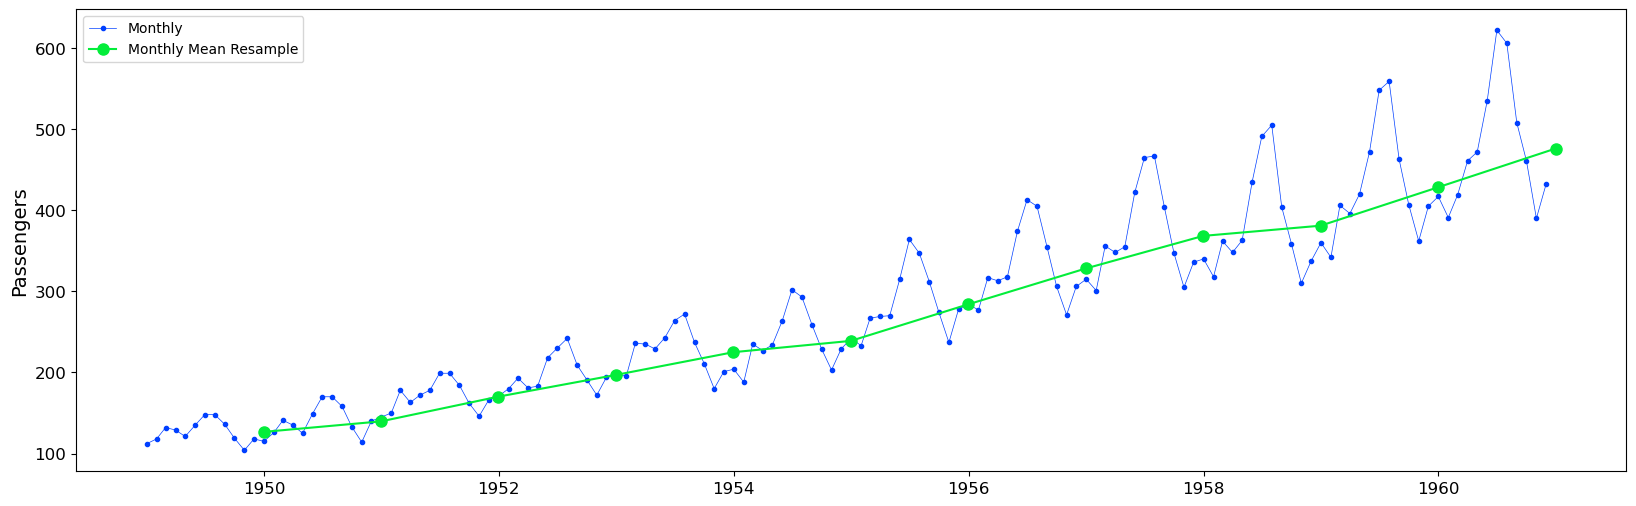

In [5]:
import warnings
import matplotlib.pyplot as plt
y = df['Passengers']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Monthly')
ax.plot(y.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Passengers')
ax.legend();

## Decomposing the Data

In [6]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

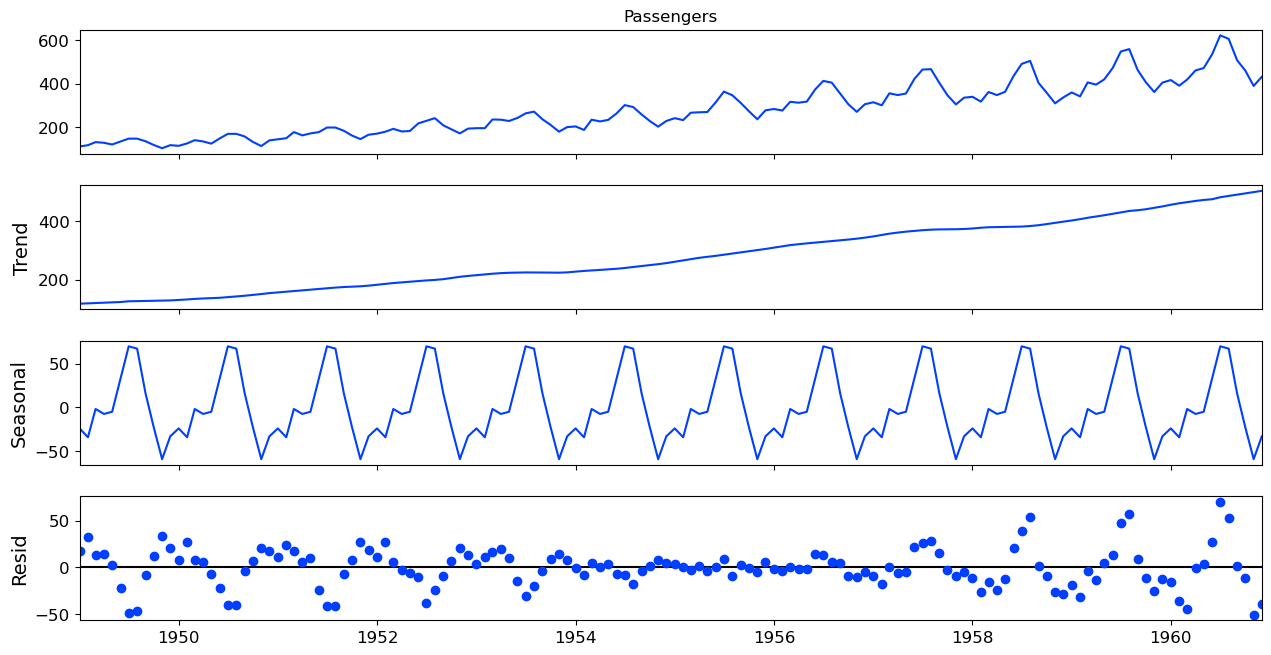

In [7]:
seasonal_decompose(y)

## Checking Stationarity

**Visualization: Graphing the rolling statistics**

In [8]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

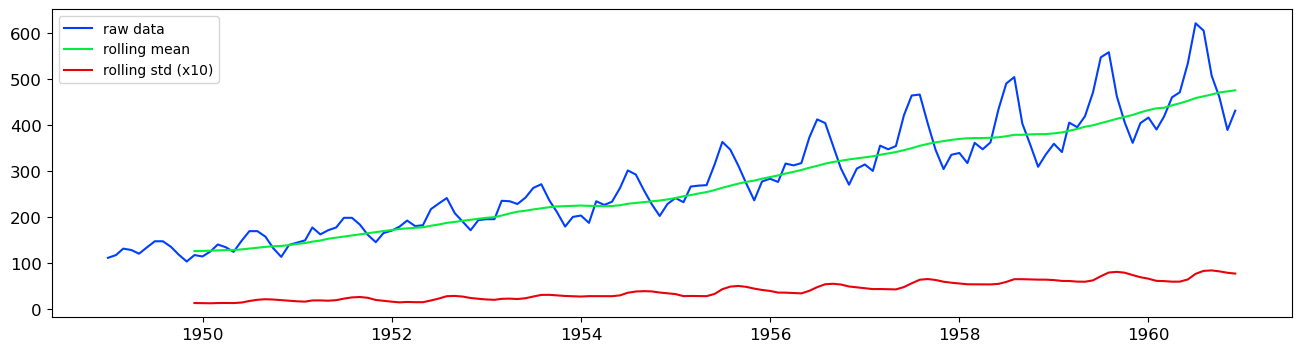

In [9]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

**Augmented Dickey-Fuller Test**

In [10]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [11]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = 0.815
P-value = 0.992
Critical values :
	1%: -3.4816817173418295 - The data is not stationary with 99% confidence
	5%: -2.8840418343195267 - The data is not stationary with 95% confidence
	10%: -2.578770059171598 - The data is not stationary with 90% confidence


**Detrending**

 > Is the de-trended data stationary ?
Test statistic = -2.895
P-value = 0.046
Critical values :
	1%: -3.4846672514209773 - The data is not stationary with 99% confidence
	5%: -2.8853397507076006 - The data is  stationary with 95% confidence
	10%: -2.5794629869786503 - The data is  stationary with 90% confidence


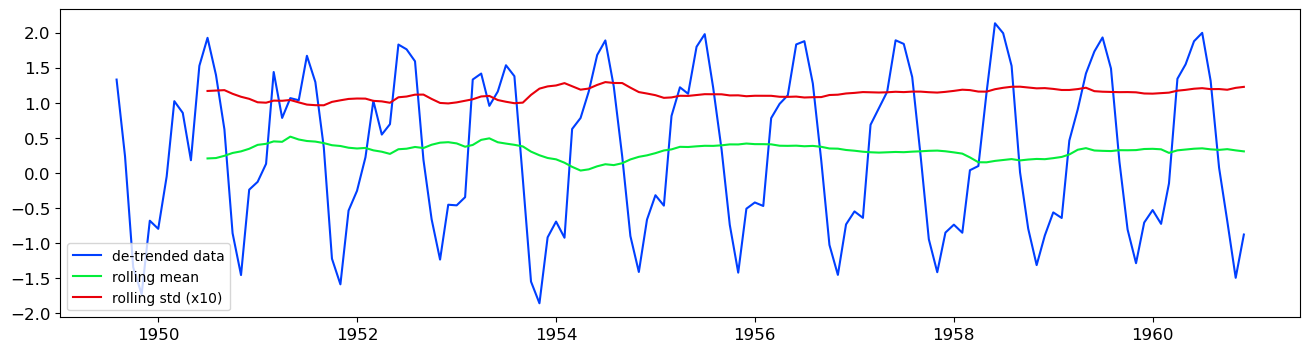

In [12]:
# Detrending
window = 8
y_detrend =  (y - y.rolling(window).mean())/y.rolling(window).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

**Differencing**

 > Is the 12 lag differenced data stationary ?
Test statistic = -3.383
P-value = 0.012
Critical values :
	1%: -3.4816817173418295 - The data is not stationary with 99% confidence
	5%: -2.8840418343195267 - The data is  stationary with 95% confidence
	10%: -2.578770059171598 - The data is  stationary with 90% confidence


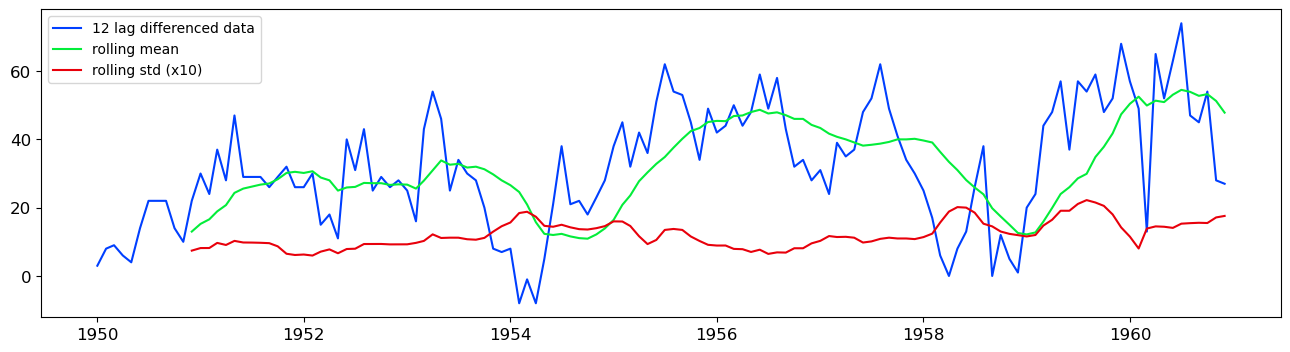

In [13]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

**Detrending + Differencing**

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -3.987
P-value = 0.001
Critical values :
	1%: -3.4901313156261384 - The data is  stationary with 99% confidence
	5%: -2.8877122815688776 - The data is  stationary with 95% confidence
	10%: -2.5807296460459184 - The data is  stationary with 90% confidence


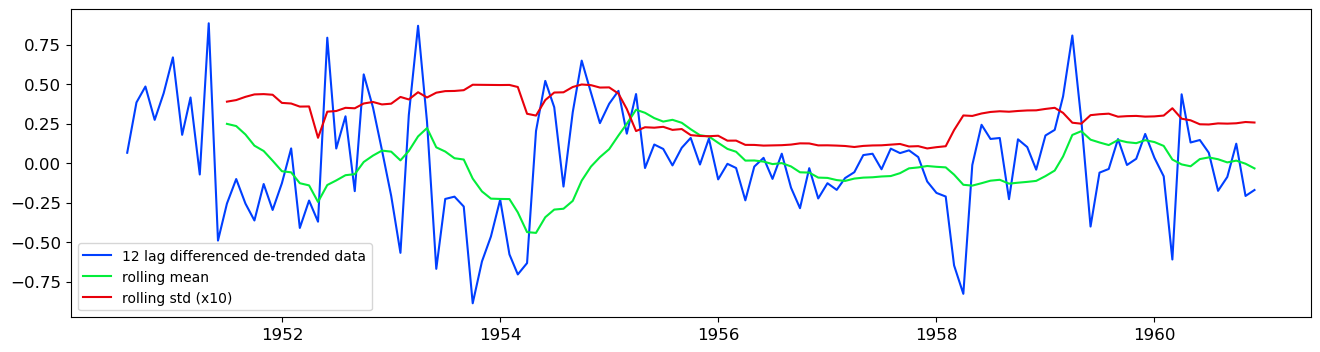

In [14]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

## Create Training & Testing Datasets

**Set the y_to_train, y_to_test, and the length of predict units**

In [15]:
y_to_train = y[:'1959-12-01'] # dataset to train
y_to_val = y['1960-01-01':] # last X months for test  
predict_date = len(y) - len(y[:'1960-01-01']) # the number of data points for the test set

## Different Time Series Prediction Models

**Simple Exponential Smoothing (SES)**

In [16]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 111.69
The Root Mean Squared Error of our forecasts with auto optimization is 107.4


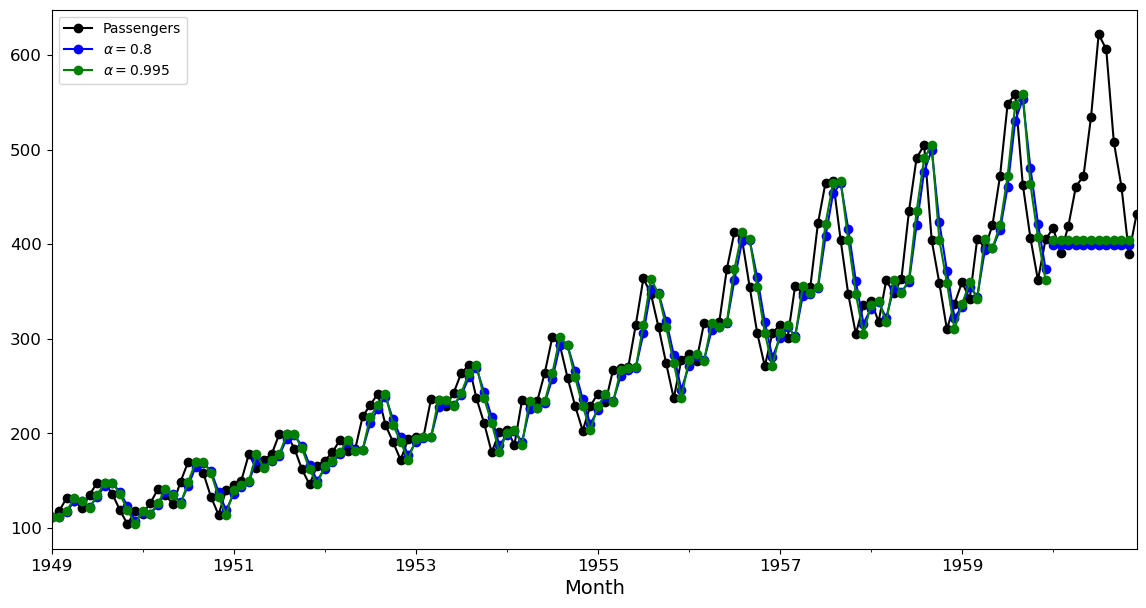

In [17]:
ses(y, y_to_train,y_to_val,0.8,predict_date)

**Holt’s Linear Trend Method**

In [18]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

The Root Mean Squared Error of Holts Linear trend 166.7
The Root Mean Squared Error of Holts Exponential trend 144.91


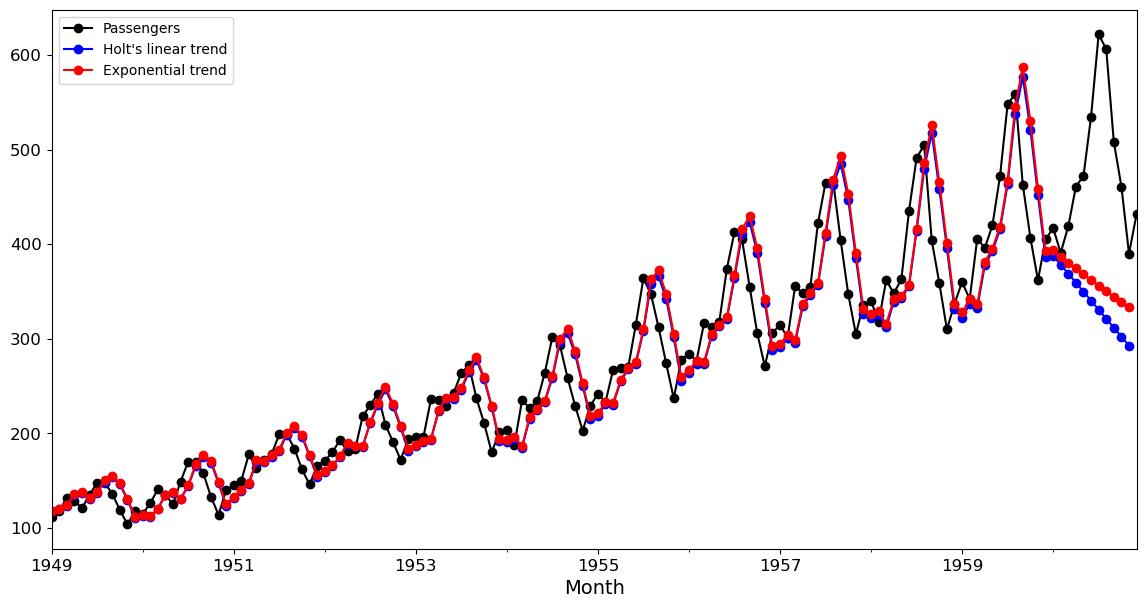

In [19]:
holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)

**SARIMA**

In [20]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [21]:
sarima_grid_search(y,12)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:920.3192974988743


In [22]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    rmse = np.sqrt(mse)
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period, round(rmse, 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()
    
    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    rmse_dynamic = np.sqrt(mse_dynamic)
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period, round(rmse_dynamic, 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    # Calcular MAE (nuevo código)
    mae = np.abs(y_forecasted_dynamic - y_to_test).mean()
    print('The Mean Absolute Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period, round(mae, 2)))
    
    return results

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2298      0.401     -0.573      0.567      -1.016       0.557
ma.L1         -0.0987      0.374     -0.264      0.792      -0.832       0.634
ar.S.L12      -0.5460      0.299     -1.825      0.068      -1.133       0.041
ma.S.L12       0.3959      0.352      1.125      0.261      -0.294       1.086
sigma2       140.2945     17.997      7.795      0.000     105.020     175.569


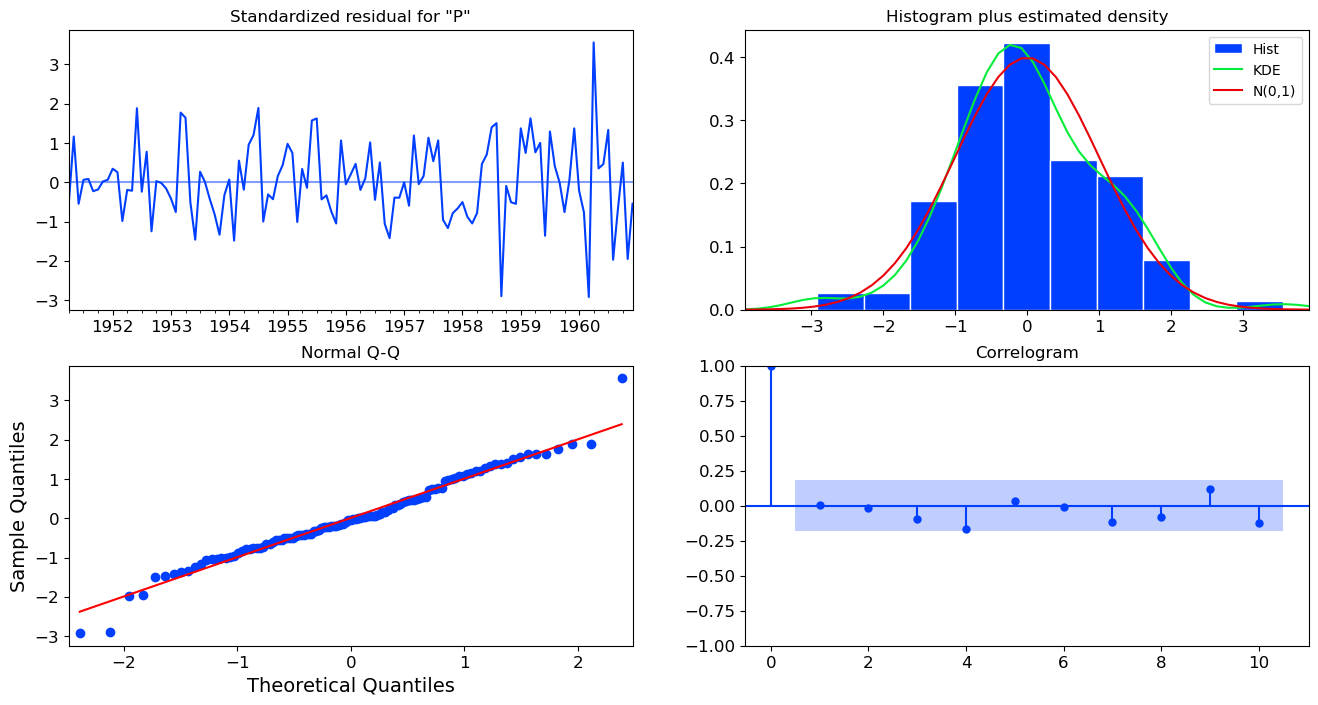

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 19.54


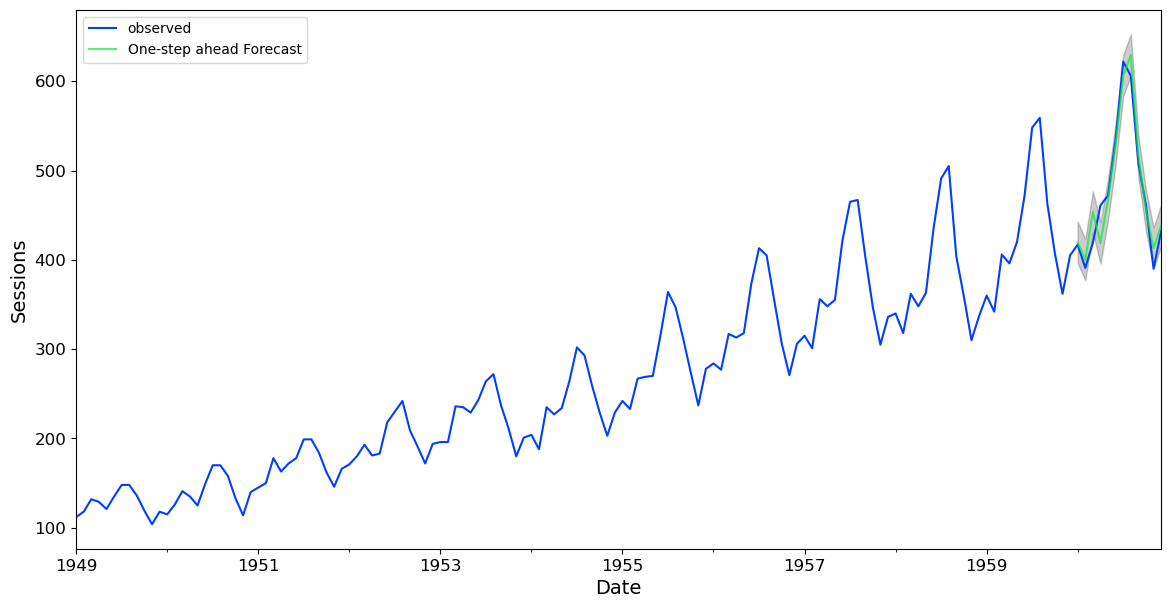

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 18.04


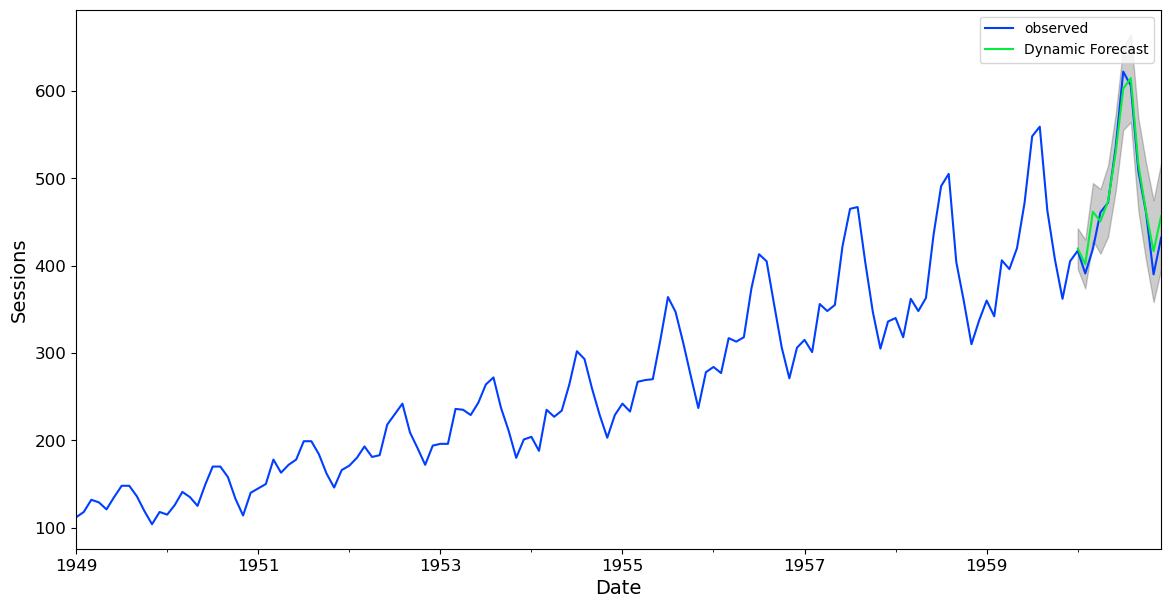

The Mean Absolute Error of SARIMA with season_length=12 and dynamic = True 13.52


In [23]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 1, 12),12,'1960-01-01',y_to_val)

## Making Predictions

In [24]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

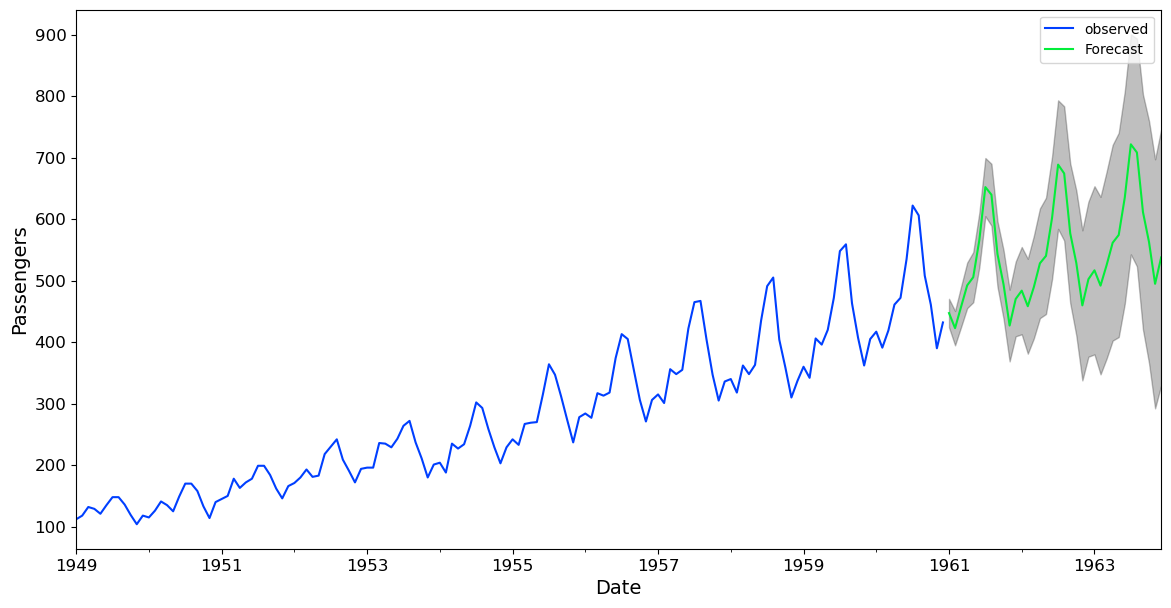

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,1961-01-01,447.22261938,424.00763072,470.43760803
1,1961-02-01,422.73409810,394.77141821,450.69677800
2,1961-03-01,457.70089435,424.79789850,490.60389020
3,1961-04-01,492.27750467,455.27083199,529.28417734
4,1961-05-01,505.56336530,464.82609309,546.30063752


In [25]:
final_table = forecast(model,36,y)
final_table.head()

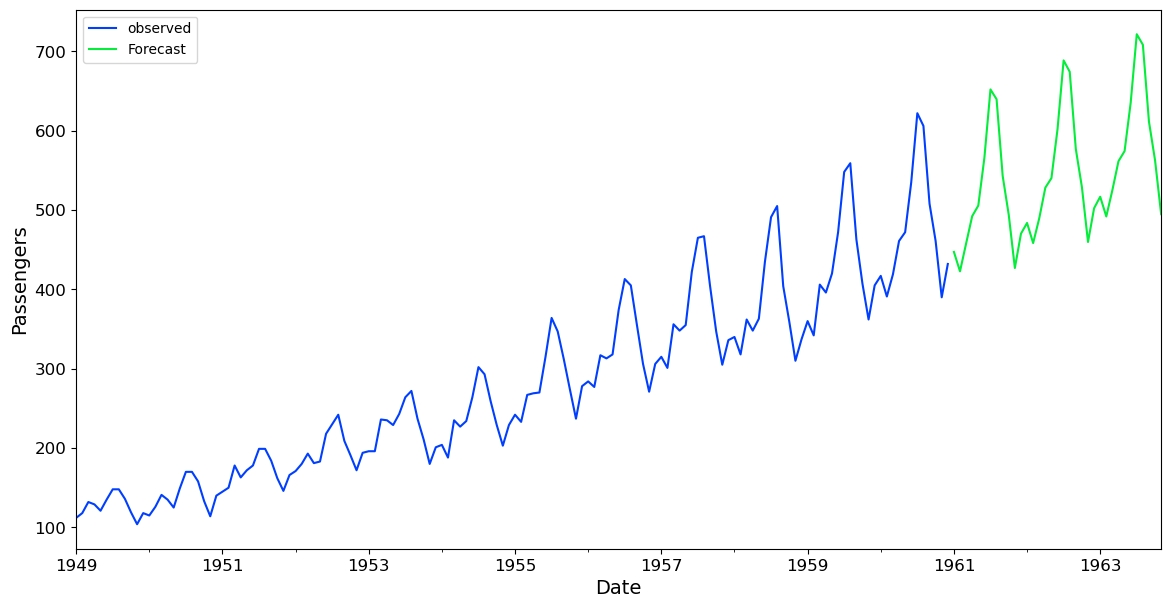

In [26]:
### Graphs without the confident interval 
pred_uc = model.get_forecast(steps=35)
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

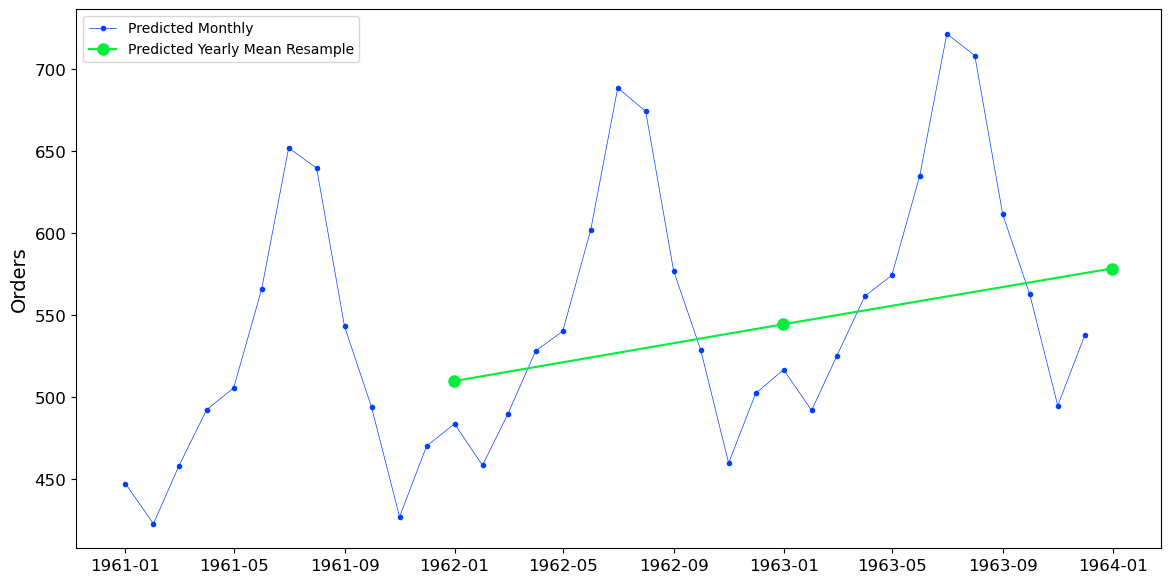

In [27]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Monthly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Yearly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

In [28]:
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound
Date,,,,
1961-01-01,1961-01-01,447.22261938,424.00763072,470.43760803
1961-02-01,1961-02-01,422.73409810,394.77141821,450.69677800
1961-03-01,1961-03-01,457.70089435,424.79789850,490.60389020
1961-04-01,1961-04-01,492.27750467,455.27083199,529.28417734
1961-05-01,1961-05-01,505.56336530,464.82609309,546.30063752
1961-06-01,1961-06-01,565.67178158,521.52619729,609.81736587
1961-07-01,1961-07-01,651.98640367,604.67566234,699.29714500
1961-08-01,1961-08-01,639.63424202,589.35759098,689.91089306
1961-09-01,1961-09-01,543.05884466,489.98167610,596.13601321


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the SARIMAX model and the time series data
model = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Create a forecast object
forecast = model_fit.get_forecast(steps=36)

# Get the confidence intervals for the forecast
conf_int = forecast.conf_int()

# Convert the forecast object to a Pandas DataFrame
forecast_df = pd.DataFrame(forecast.predicted_mean)
forecast_df.columns = ['Predicted_Mean']

# Add the observations to the DataFrame
forecast_df['Observations'] = y

# Combine the forecast DataFrame with the original DataFrame
final_df = pd.concat([y, forecast_df], axis=1)

# Print the combined DataFrame
print(final_df)

             Passengers  Predicted_Mean  Observations
1949-01-01 112.00000000             NaN           NaN
1949-02-01 118.00000000             NaN           NaN
1949-03-01 132.00000000             NaN           NaN
1949-04-01 129.00000000             NaN           NaN
1949-05-01 121.00000000             NaN           NaN
...                 ...             ...           ...
1963-08-01          NaN    709.03541762           NaN
1963-09-01          NaN    614.02085716           NaN
1963-10-01          NaN    564.60474289           NaN
1963-11-01          NaN    495.35102577           NaN
1963-12-01          NaN    538.80690028           NaN

[180 rows x 3 columns]


In [30]:
# Save the combined DataFrame to a CSV file
final_df.to_csv('final_df.csv')